### Imports

In [55]:
import chess
import chess.engine
import chess.svg

from chess.engine import EngineTerminatedError

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from IPython.display import SVG, display

from utils.data_utils import read
from utils.chess_utils import Player, evaluate_all_moves_simple_engine

### Stockfish engine path

In [2]:
engine_path = "engine/stockfish/stockfish-windows-x86-64-avx2.exe"

### Utils

In [3]:
def plot_heuristic_scores(heuristic_scores, optimal_scores, show_all=True, n_shown=10, figsize=(12, 5)):
    '''
    Displays the difference in move scores of heuristic and stockfish player.

    Parameters
    - heuristic_scores (List(float)): List of stockfish evaluations of the heurstic player moves.
    - optimal_scores (List(float)): List of stockfish evaluations of the optimal player moves.
    - show_all (bool): If True, all move scores are displayed. Default: True.
    - n_shown (int): If show_all is False, n_shown move scores are displayed. Default: 10.
    - figsize (Tuple(int,int)): Figure size. Default: (15, 7).
    '''
    fig, ax = plt.subplots()
    
    fig.set_figheight(figsize[1])
    fig.set_figwidth(figsize[0])

    heuristic_scores = np.array(heuristic_scores)
    optimal_scores = np.array(optimal_scores)
    
    assert len(heuristic_scores) == len(optimal_scores)

    if show_all:
        n_shown = len(heuristic_scores)

    n_shown = n_shown if n_shown <= len(heuristic_scores) else len(heuristic_scores)

    a = ax.bar(range(1, n_shown+1), heuristic_scores[:n_shown], label="heuristic")
    # ax.bar(range(1, n+1), -optimal_scores[:n], label="optimal")
    b = ax.plot(range(1, n_shown+1), optimal_scores[:n_shown], marker="+", linestyle="", color="red", markersize=12, label="optimal")

    ax.set_title("Heuristic vs optimal move stockfish scores")
    ax.legend(loc="upper right", handles=[a, b[0]])
    ax.grid(axis="y")

    ax.set_xlabel("move")
    ax.set_ylabel("score")


def play_stockfish(player, engine_path, player_color=chess.WHITE, display_board=False):
    '''
    Plays a game using the player class object against a stockfish opponent.

    Parameters
    - player (Player): Heuristic player inheriting the Player class.
    - engine_path (str): Path to chess engine.
    - player_color (bool): chess.WHITE or chess.BLACK. Default: chess.WHITE.
    - display_board (bool): If true, displays SVG boards after each heuristic and stockfish opponent move.

    Returns
    - heuristic_scores (List(float)): List of heuristic player move scores.
    - optimal_scores (List(float)): List of stockfish player move scores.
    '''
    board = chess.Board()

    eval_engine = chess.engine.SimpleEngine.popen_uci(engine_path)
    heuristic_scores = []
    optimal_scores = []

    print("Running game...")
    while not player.is_game_over(board):
        if board.turn == player_color:
            # Play optimal stockfish move
            result = eval_engine.play(board, chess.engine.Limit(time=0.1))            
            board.push(result.move)            
            info = eval_engine.analyse(board, chess.engine.Limit(time=0.1))
            optimal_score = info['score'].pov(player_color).score(mate_score=900)
            # print(info['score'].pov(chess.WHITE).score(mate_score=10000))
            # display(SVG(chess.svg.board(board, size=300)))
            board.pop()
            
            move = player.get_best_move(board)
            player.play_move(move, board)
            info = eval_engine.analyse(board, chess.engine.Limit(time=0.1))
            heuristic_score = info['score'].pov(player_color).score(mate_score=900)
            # print(info['score'].pov(chess.WHITE).score(mate_score=10000))

            if display_board:
                display(SVG(chess.svg.board(board, lastmove=move, size=300)))

            # Store scores for plotting
            heuristic_scores.append(heuristic_score)
            optimal_scores.append(optimal_score)

        else:
            # Play optimal stockfish move
            result = eval_engine.play(board, chess.engine.Limit(time=0.1))
            board.push(result.move)
            
            if display_board:
                display(SVG(chess.svg.board(board, lastmove=result.move, size=300)))

    print(f"Winner: {board.outcome().result()}")

    # Close the engines
    eval_engine.quit()

    return heuristic_scores, optimal_scores

## Heuristic 1: Dynamic depth stockfish

Adjust the depth parameter of stockfish based on game state

In [4]:
class HumanHeuristicSimpleStockfish(Player):
    def __init__(self, engine_path, min_depth=1, max_depth=5):
        self.engine = chess.engine.SimpleEngine.popen_uci(engine_path)
        self.min_depth = min_depth
        self.max_depth = max_depth
        self.last_move = None

        print(self.engine)

    def play_move(self, move, board):
        '''
        Play chosen move.

        Parameters
        - move (chess.Move): The move to be played.
        - board (chess.Board): The current state of the chess board.
        '''
        board.push(move)
        self.last_move = move

    def get_best_move(self, board):
        '''
        Get the best move for a given position according to players strategy.

        Parameters
        - board (chess.Board): The current state of the chess board.

        Returns
        - chess.Move: The best move calculated by the engine.
        '''
        # Calculate number of pieces on the board
        num_pieces = len(board.piece_map())
        
        # Determine the depth based on the number of pieces
        if num_pieces > 24:  # Early game, use shallow depth
            depth = self.min_depth
        elif num_pieces > 12:  # Mid game, increase depth
            depth = (self.min_depth + self.max_depth) // 2
        else:  # End game, use maximum depth
            depth = self.max_depth

        # Get the best move from the engine with the determined depth
        result = self.engine.play(board, chess.engine.Limit(time=0.1, depth=depth))
        return result.move

    def is_game_over(self, board):
        '''
        Check if the game is over.

        Parameters
        - board (chess.Board): The current state of the chess board.

        Returns
        - bool: True if the game is over, False otherwise.
        '''
        return board.is_game_over()

    def display_board(self, board, size=300):
        '''
        Display the current state of the chess board.

        Parameters
        - board (chess.Board): The current state of the chess board.
        '''
        if self.last_move:
            svg_board = chess.svg.board(board, lastmove=self.last_move, size=size)
        else:
            svg_board = chess.svg.board(board, size=size)
        display(SVG(svg_board))

    def close_engine(self):
        '''
        Close the chess engine.
        '''
        self.engine.quit()

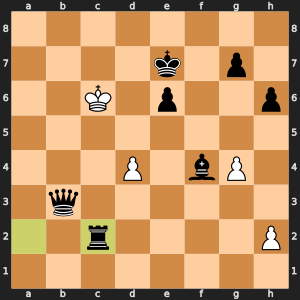

Game over


In [4]:
board = chess.Board()
player = HumanHeuristicSimpleStockfish(engine_path)

while not player.is_game_over(board):
    # player.display_board(board, size=300)
    move = player.get_best_move(board)
    player.play_move(move, board)

player.display_board(board)
print("Game over")
player.close_engine()

In [5]:
player = HumanHeuristicSimpleStockfish(engine_path)
heuristic_scores, optimal_scores = play_stockfish(player, engine_path, chess.WHITE)
player.close_engine()

<SimpleEngine (pid=4108)>
Running game...
Winner: 0-1


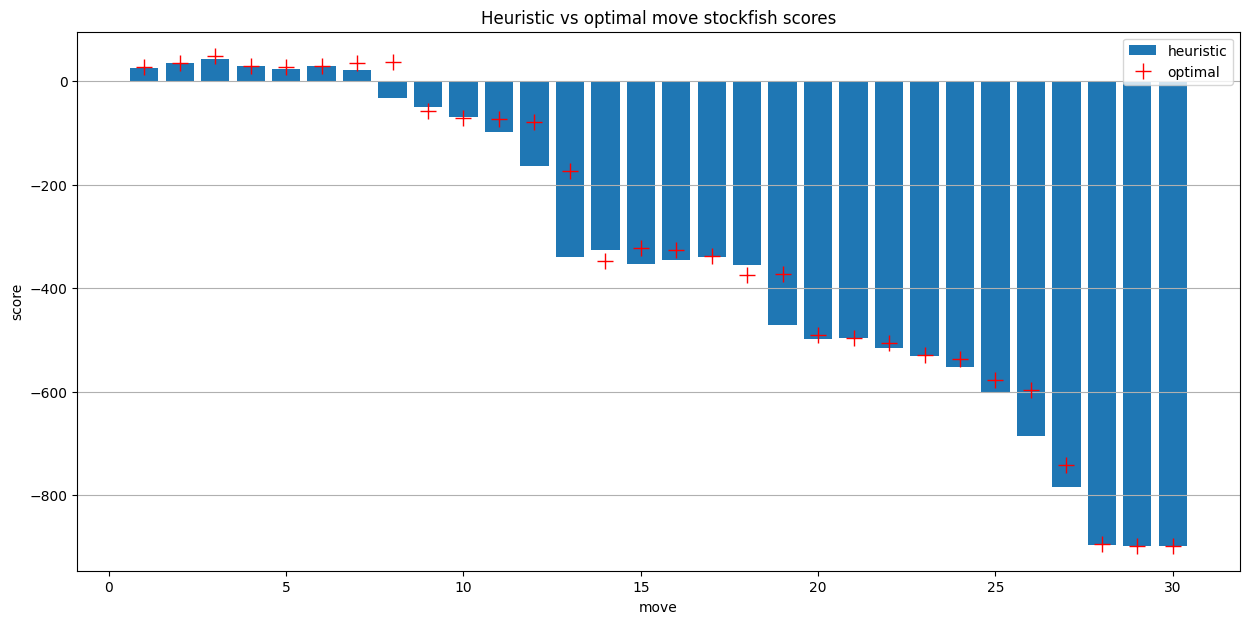

In [6]:
plot_heuristic_scores(heuristic_scores, optimal_scores)

In [14]:
board = chess.Board()
player = HumanHeuristicSimpleStockfish(engine_path, 1, 2)

# Load a separate evaluation engine instance for full-depth analysis
eval_engine = chess.engine.SimpleEngine.popen_uci(engine_path)

white_heuristic_scores = []
white_optimal_scores = []

black_heuristic_scores = []
black_optimal_scores = []

while not player.is_game_over(board):
    # Play optimal stockfish move
    result = eval_engine.play(board, chess.engine.Limit(time=0.1))
    board.push(result.move)
    info = eval_engine.analyse(board, chess.engine.Limit(time=0.1))
    optimal_score = info['score'].pov(board.turn).score(mate_score=10000)
    # print(info['score'].pov(board.turn).score(mate_score=10000))
    # display(SVG(chess.svg.board(board, size=300)))
    board.pop()

    move = player.get_best_move(board)
    player.play_move(move, board)
    info = eval_engine.analyse(board, chess.engine.Limit(time=0.1))
    heuristic_score = info['score'].pov(board.turn).score(mate_score=10000)
    # print(info['score'].pov(board.turn).score(mate_score=10000))
    # display(SVG(chess.svg.board(board, size=300)))
    
    # Store scores for plotting
    if board.turn == chess.WHITE:
        white_heuristic_scores.append(heuristic_score)
        white_optimal_scores.append(optimal_score)

    else:
        black_heuristic_scores.append(heuristic_score)
        black_optimal_scores.append(optimal_score)

print(f"Winner: {board.outcome().result()}")

# Close the engines
player.close_engine()
eval_engine.quit()

Winner: 0-1


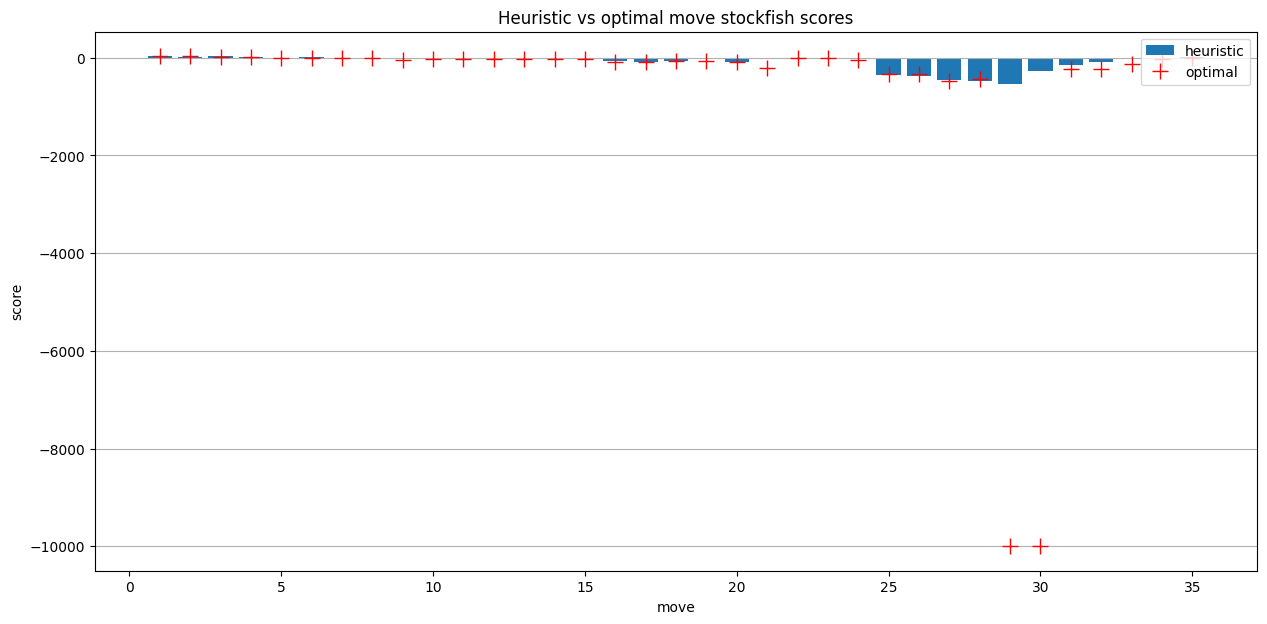

In [15]:
plot_heuristic_scores(white_heuristic_scores, white_optimal_scores, show_all=False, n_shown=35)

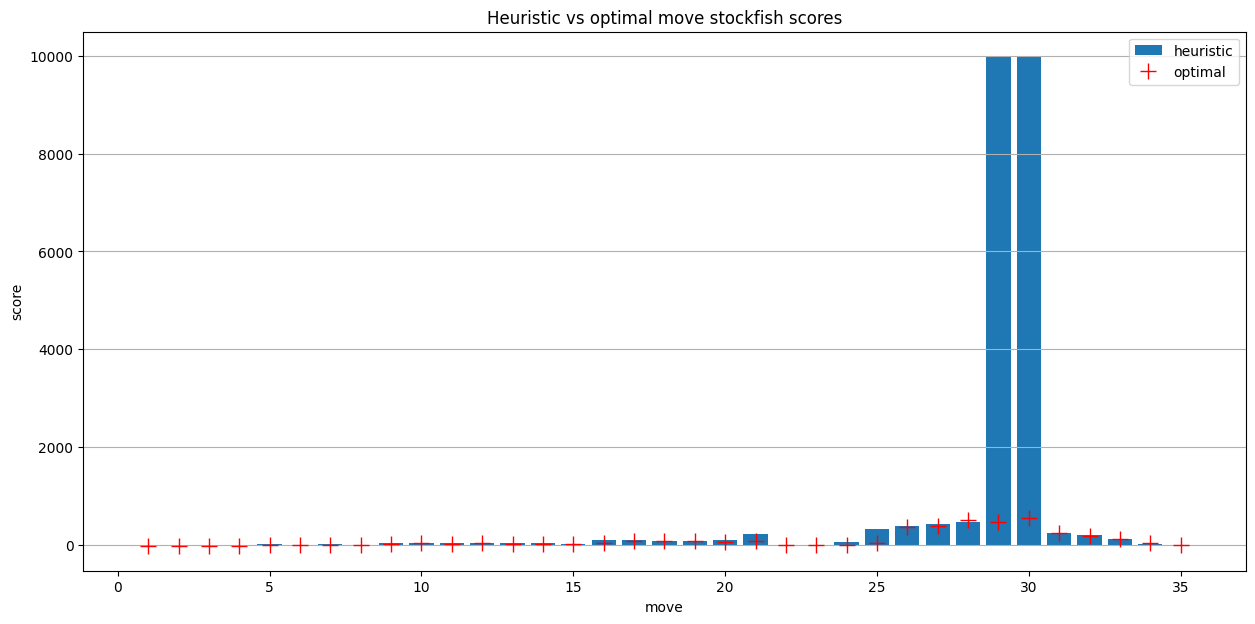

In [16]:
plot_heuristic_scores(black_heuristic_scores, black_optimal_scores, show_all=False, n_shown=35)

## Heuristic 2: Probabilistic stockfish

Use human move quality distribution information to select from all legal moves based on stockfish evaluation (*chess_utils.evaluate_all_moves_simple_engine*) or from *n* multipv moves (*engine.analyse(board, multipv=n)*)

use the position of move e.g. 5th best move out of 20 -> 3/4 quality or the move quality normalized e.g. scores [-10, -5, -3, -2, 0] and move -5 was selected -> 1/2 quality

separate by elo
maybe separate and depending on multipv/all legal

TODO: use a bigger/newer dataset

In [7]:
df = read(data_file = "data\\game_batch_0.npy.gz", column_names_file = "data\\column_names.txt")

# TODO read other dfs and concat

df.shape

(142542, 44)

In [8]:
df = df[df.human == True]
df.shape

(71771, 44)

In [9]:
df.columns

Index(['human', 'player', 'elo', 'color', 'event', 'clock',
       'stockfish_score_depth_1', 'stockfish_difference_depth_1',
       'stockfish_score_depth_2', 'stockfish_difference_depth_2',
       'stockfish_score_depth_3', 'stockfish_difference_depth_3',
       'stockfish_score_depth_4', 'stockfish_difference_depth_4',
       'stockfish_score_depth_5', 'stockfish_difference_depth_5',
       'stockfish_score_depth_8', 'stockfish_difference_depth_8',
       'stockfish_score_depth_10', 'stockfish_difference_depth_10',
       'stockfish_score_depth_12', 'stockfish_difference_depth_12',
       'stockfish_score_depth_15', 'stockfish_difference_depth_15',
       'stockfish_score_depth_16', 'stockfish_difference_depth_16',
       'stockfish_score_depth_18', 'stockfish_difference_depth_18',
       'stockfish_score_depth_20', 'stockfish_difference_depth_20',
       'past_move_1', 'past_move_2', 'past_move_3', 'past_move_4',
       'past_move_5', 'past_move_6', 'past_move_7', 'past_move_8',
  

In [64]:
# df[[x for x in df.columns if "stockfish" in x]]

,stockfish_score_depth_1,stockfish_difference_depth_1,stockfish_score_depth_2,stockfish_difference_depth_2,stockfish_score_depth_3,stockfish_difference_depth_3,stockfish_score_depth_4,stockfish_difference_depth_4,stockfish_score_depth_5,stockfish_difference_depth_5,...,stockfish_score_depth_12,stockfish_difference_depth_12,stockfish_score_depth_15,stockfish_difference_depth_15,stockfish_score_depth_16,stockfish_difference_depth_16,stockfish_score_depth_18,stockfish_difference_depth_18,stockfish_score_depth_20,stockfish_difference_depth_20
1,-45,-15,-45,-17,-45,-15,-39,-12,-41,-14,...,-43,-7,-42,-6,-38,1,-35,10,-46,-1
2,704,-7,704,-7,704,-7,704,-7,704,-7,...,712,71,712,3,703,1,677,-25,744,62
3,-486,-6,-486,-6,-486,-6,-486,-6,-486,-6,...,-519,-45,-496,-14,-504,-32,-474,1,-511,-51
5,110,-143,103,-150,103,-150,103,-150,82,-171,...,175,4,166,-3,160,39,181,71,181,71
7,-283,2,-283,2,-283,10,-283,11,-283,11,...,-339,-34,-397,-118,-371,-110,-366,-83,-411,-128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142529,211,-28,213,-26,213,-26,213,-26,213,-26,...,226,-9,253,27,254,8,165,-73,188,-31
142530,10,-26,2,-57,0,-59,0,-34,-6,-43,...,30,-20,32,-15,32,-5,19,-28,25,-21
142532,41,105,41,105,43,107,43,73,43,11,...,25,-14,30,-14,30,-12,34,-7,33,-8
142534,37,20,37,2,37,2,37,-16,37,-40,...,68,15,63,28,53,20,51,-9,67,30


In [10]:
df = df[["human", "player", "elo", "color", "event", "clock", "current_move_str", "current_move", "past_move_12"]]

In [11]:
df = df.astype({"elo": np.uint16})
df.elo.dtype

dtype('uint16')

In [12]:
df.elo.max(axis=0), df.elo.min(axis=0)

(2500, 857)

In [ ]:
def get_elo_container(elo):
    return min(10, max(1, (elo - 1000) // 100 + 1))

In [ ]:

df["elo_range"] = df.elo.apply(get_elo_container)
df.elo_range.dtype

In [94]:
get_elo_container(1899)

9

In [14]:
print(f"Number of players in elo ranges:")
for i in range(1, 11):
    print(f"{i}: {df[df.elo_range == i].shape[0]}")

Number of players in elo ranges:
1: 1741
2: 2096
3: 3614
4: 6938
5: 7642
6: 8446
7: 9706
8: 9944
9: 8777
10: 12867


In [15]:
df.head(5)

,human,player,elo,color,event,clock,current_move_str,current_move,past_move_12,elo_range
1,True,Pawnbeast,1912,Black,Rated Classical tournament https://lichess.org...,299.0,r1bqkbnr/pp1ppppp/2n5/2p5/4P3/5N2/PPPP1PPP/RNB...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...",10
2,True,mars33,1830,White,Rated Blitz tournament https://lichess.org/tou...,17.0,r7/1p2Np2/p2p2kp/5q2/3p2rP/5Q2/PP5K/4R3 b - - ...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...",9
3,True,guarany9,1725,White,Rated Blitz tournament https://lichess.org/tou...,164.0,r1bq1rk1/pp3ppp/3b4/3Qp3/1P6/P3PN1P/5PP1/R1B1K...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...",8
5,True,MejoDeScarsen,1644,White,Rated Blitz game,244.0,rnbqkbnr/1ppppp2/6p1/p7/2PPP3/2NB3N/PP3PPP/R1B...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...",7
7,True,Argo111,1170,Black,Rated Blitz game,289.0,rnbqk1nr/pp5p/4Ppp1/3B4/1b6/5N2/PPP2PPP/RNBQK2...,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1...",2


In [16]:
df.columns

Index(['human', 'player', 'elo', 'color', 'event', 'clock', 'current_move_str',
       'current_move', 'past_move_12', 'elo_range'],
      dtype='object')

In [17]:
def bitboard_to_fen(bitboard):
    '''
    Transforms a bitboard back to a FEN representation of a board.

    Parameters
    - bitboard (numpy.ndarray): The current state of the chess board in bitboard representation. 
    The bitboard should contain only the current piece position in the following order: ["p", "r", "n", "b", "q", "k", "P", "R", "N", "B", "Q", "K"]

    Returns
    - str: FEN representation of the board.
    '''

    # Piece symbols for white and black
    pieces =  ["p", "r", "n", "b", "q", "k", "P", "R", "N", "B", "Q", "K"]
    
    # Initialize an empty 8x8 board with empty squares represented by '.'
    board = np.full((8, 8), '.', dtype=str)

    # Fill the board with the pieces based on the bitboard
    for i in range(12):
        piece_positions = bitboard[i]
        piece_symbol = pieces[i]
        for rank in range(8):
            for file in range(8):
                if piece_positions[rank, file] == 1:
                    board[rank, file] = piece_symbol

    # Convert the board to FEN
    fen_rows = []
    for rank in range(8):
        fen_row = ""
        empty_count = 0
        for file in range(8):
            if board[rank, file] == '.':
                empty_count += 1
            else:
                if empty_count > 0:
                    fen_row += str(empty_count)
                    empty_count = 0
                fen_row += board[rank, file]
        if empty_count > 0:
            fen_row += str(empty_count)
        fen_rows.append(fen_row)
    
    fen = "/".join(fen_rows)
    
    return fen

bitboard_to_fen(df.current_move.iloc[0][:12]) == df.current_move_str.iloc[0].split(" ")[0]

True

In [18]:
df.current_move_str.iloc[0], bitboard_to_fen(df.current_move.iloc[0][:12])

('r1bqkbnr/pp1ppppp/2n5/2p5/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 2 3',
 'r1bqkbnr/pp1ppppp/2n5/2p5/4P3/5N2/PPPP1PPP/RNBQKB1R')

In [19]:
df["past_move_str"] = df.past_move_12.apply(bitboard_to_fen)

In [20]:
df = df.drop(["past_move_12", "current_move"], axis=1)
df.head(3)

,human,player,elo,color,event,clock,current_move_str,elo_range,past_move_str
1,True,Pawnbeast,1912,Black,Rated Classical tournament https://lichess.org...,299.0,r1bqkbnr/pp1ppppp/2n5/2p5/4P3/5N2/PPPP1PPP/RNB...,10,rnbqkbnr/pp1ppppp/8/2p5/4P3/5N2/PPPP1PPP/RNBQKB1R
2,True,mars33,1830,White,Rated Blitz tournament https://lichess.org/tou...,17.0,r7/1p2Np2/p2p2kp/5q2/3p2rP/5Q2/PP5K/4R3 b - - ...,9,r7/1p3p2/p2p2kp/3N1q2/3p2rP/5Q2/PP5K/4R3
3,True,guarany9,1725,White,Rated Blitz tournament https://lichess.org/tou...,164.0,r1bq1rk1/pp3ppp/3b4/3Qp3/1P6/P3PN1P/5PP1/R1B1K...,8,r1bq1rk1/pp3ppp/3b4/3np3/1P6/P3PN1P/5PP1/R1BQK2R


In [95]:
df.columns

Index(['human', 'player', 'elo', 'color', 'event', 'clock', 'current_move_str',
       'elo_range', 'past_move_str'],
      dtype='object')

True


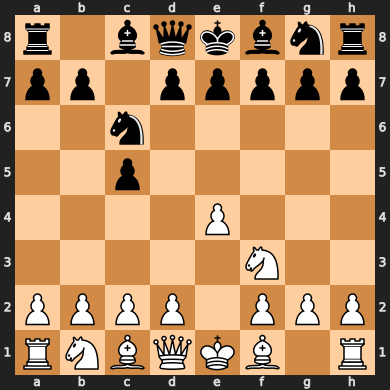

In [85]:
current_board = chess.Board(df.current_move_str.iloc[0])

assert current_board.fen() != chess.STARTING_FEN, "Current board should not be a starting position"

current_board.turn = chess.BLACK if df.iloc[0].color.lower() == "white" else chess.WHITE

print(current_board.turn)
current_board

False


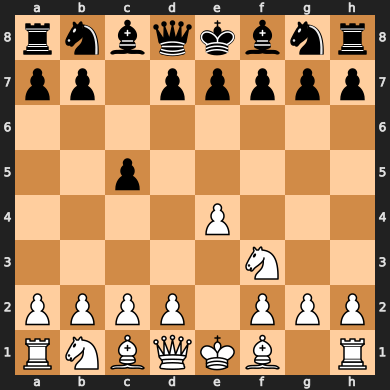

In [21]:
past_board = chess.Board(df.past_move_str.iloc[0])
past_board.turn = chess.WHITE if df.iloc[0].color.lower() == "white" else chess.BLACK

print(past_board.turn)
past_board

In [67]:
eval_engine = chess.engine.SimpleEngine.popen_uci(engine_path)

player_turn = past_board.turn

all_moves = list(past_board.legal_moves)
move_scores = {}
for move in all_moves:
    past_board.push(move)
    info = eval_engine.analyse(past_board, chess.engine.Limit(time=0.1))
    score = info['score'].pov(player_turn).score(mate_score=1000)
    move_scores[move] = score
    if past_board.fen().split(" ")[0] == current_board.fen().split(" ")[0]:
        player_move_score = [move, score]
    past_board.pop()

eval_engine.quit()
move_scores, player_move_score

({Move.from_uci('g8h6'): -106,
  Move.from_uci('g8f6'): -66,
  Move.from_uci('d8c7'): -62,
  Move.from_uci('d8b6'): -93,
  Move.from_uci('d8a5'): -63,
  Move.from_uci('b8c6'): -28,
  Move.from_uci('b8a6'): -112,
  Move.from_uci('h7h6'): -49,
  Move.from_uci('g7g6'): -57,
  Move.from_uci('f7f6'): -131,
  Move.from_uci('e7e6'): -34,
  Move.from_uci('d7d6'): -30,
  Move.from_uci('b7b6'): -63,
  Move.from_uci('a7a6'): -47,
  Move.from_uci('c5c4'): -241,
  Move.from_uci('h7h5'): -73,
  Move.from_uci('g7g5'): -191,
  Move.from_uci('f7f5'): -156,
  Move.from_uci('e7e5'): -183,
  Move.from_uci('d7d5'): -106,
  Move.from_uci('b7b5'): -175,
  Move.from_uci('a7a5'): -169},
 [Move.from_uci('b8c6'), -28])

In [97]:
df["boards"] = df.current_move_str.apply(chess.Board)
df.boards.head(2)

1    r . b q k b n r\np p . p p p p p\n. . n . . . ...
2    r . . . . . . .\n. p . . N p . .\np . . p . . ...
Name: boards, dtype: object

In [98]:
df.shape

(71771, 10)

In [100]:
df[df.current_move_str != chess.STARTING_BOARD_FEN]
df.shape

(71771, 10)

In [68]:
scores = np.fromiter(move_scores.values(), dtype=np.int16)
player_norm_score = (player_move_score[1] - np.min(scores)) / (np.max(scores) - np.min(scores))
player_norm_score

1.0

In [79]:
scores_nodup = list(set(scores))

player_pos_score = None
for i, s in enumerate(sorted(scores_nodup)):
    if s == player_move_score[1]:
        player_pos_score = i/(len(scores_nodup)-1)
        break

player_pos_score

1.0

<BarContainer object of 22 artists>

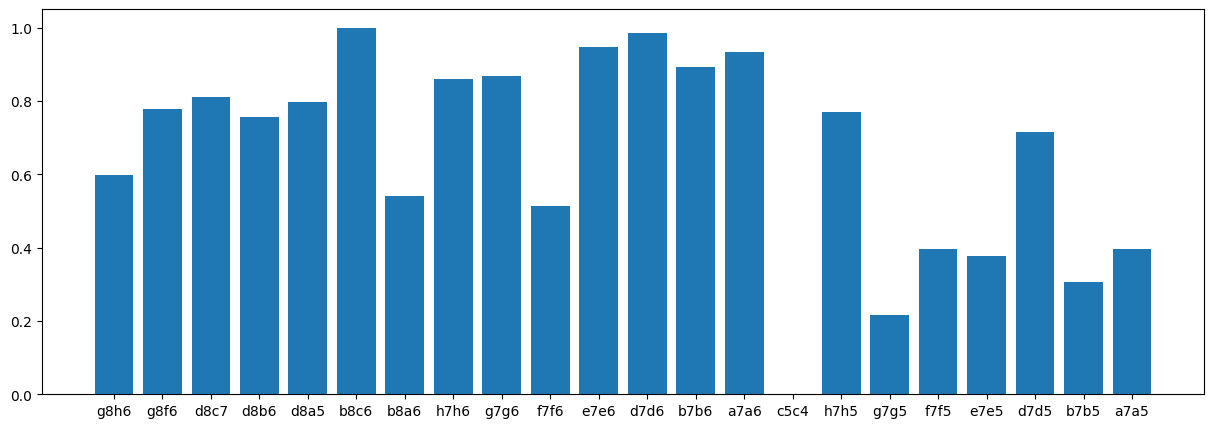

In [52]:
plt.figure(figsize=(15, 5))
norm_scores = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))
plt.bar([x.uci() for x in move_scores.keys()], norm_scores)

In [53]:
norm_scores

array([0.5990991 , 0.77927928, 0.81081081, 0.75675676, 0.7972973 ,
       1.        , 0.54054054, 0.86036036, 0.86936937, 0.51351351,
       0.94594595, 0.98648649, 0.89189189, 0.93243243, 0.        ,
       0.77027027, 0.21621622, 0.3963964 , 0.37837838, 0.71621622,
       0.30630631, 0.3963964 ])

### Utils

In [299]:
def bitboard_to_fen(bitboard):
    '''
    Transforms a bitboard back to a FEN representation of a board.

    Parameters
    - bitboard (numpy.ndarray): The current state of the chess board in bitboard representation. 
    The bitboard should contain only the current piece position in the following order: ["p", "r", "n", "b", "q", "k", "P", "R", "N", "B", "Q", "K"]

    Returns
    - str: FEN representation of the board.
    '''

    # Piece symbols for white and black
    pieces =  ["p", "r", "n", "b", "q", "k", "P", "R", "N", "B", "Q", "K"]
    
    # Initialize an empty 8x8 board with empty squares represented by '.'
    board = np.full((8, 8), '.', dtype=str)

    # Fill the board with the pieces based on the bitboard
    for i in range(12):
        piece_positions = bitboard[i]
        piece_symbol = pieces[i]
        for rank in range(8):
            for file in range(8):
                if piece_positions[rank, file] == 1:
                    board[rank, file] = piece_symbol

    # Convert the board to FEN
    fen_rows = []
    for rank in range(8):
        fen_row = ""
        empty_count = 0
        for file in range(8):
            if board[rank, file] == '.':
                empty_count += 1
            else:
                if empty_count > 0:
                    fen_row += str(empty_count)
                    empty_count = 0
                fen_row += board[rank, file]
        if empty_count > 0:
            fen_row += str(empty_count)
        fen_rows.append(fen_row)
    
    fen = "/".join(fen_rows)
    
    return fen


def get_human_move_df(df):
    '''
    Returns a dataframe with human current move and past move in fen format.
    '''
    df = df[df.human == True]
    
    # print(df.shape, df[df['past_move_12'].apply(lambda x: np.all(x == 0))].shape)  

    # Remove starting positions
    df = df[df['past_move_12'].apply(lambda x: not np.all(x == 0))]   

    df["past_move_str"] = df.past_move_12.apply(bitboard_to_fen)
    df["current_move_str"] = df.current_move.apply(bitboard_to_fen)
    df = df.drop(["past_move_12", "current_move", "human", "stockfish_score_depth_8", \
                  "stockfish_difference_depth_8", "past_move_8", "past_move_9", "past_move_10", "past_move_11"], axis=1)

    return df

def calculate_move_qualities(human_df, eval_engine, time_limit=0.1):
    '''
    Returns a dataframe with move 'position_score' and 'norm_score' qualities.

    The 'position_score' quality of a move is the position of the move selected by a human player in sorted array 
    of all legal moves ranked by stockfish divided by the length of a set of move scores (range 0.0 - 1.0). 

    The 'norm_score' quality of a move is the normalized stockfish score of the move made by a human player 
    out of all legal moves ranked by stockfish (range 0.0 - 1.0). 
    '''
    
    player_norm_scores = []
    player_pos_scores = []
    player_move_scores = []
    all_move_scores = []
    past_scores = []
    for _, row in tqdm(human_df.iterrows()):
        current_board = chess.Board(row.current_move_str)
        past_board = chess.Board(row.past_move_str)
        
        current_board.turn = 1 - row.color
        past_board.turn = row.color
        
        player_turn = past_board.turn
        
        info = eval_engine.analyse(past_board, chess.engine.Limit(time=time_limit))
        past_score = info['score'].pov(player_turn).score(mate_score=1000)

        player_move_score = None
        all_moves = list(past_board.legal_moves)
        
        move_scores = {}
        past_scores.append(past_score)
        for move in all_moves:
            past_board.push(move)
            info = eval_engine.analyse(past_board, chess.engine.Limit(time=time_limit))
            score = info['score'].pov(player_turn).score(mate_score=1000)
            move_scores[move] = score
            if past_board.fen().split(" ")[0] == current_board.fen().split(" ")[0]:
                player_move_score = [move, score]
            past_board.pop()

        if player_move_score is None:
            # If player move score is none, we assume castling took place
            # castling cannot be recognized in the reconstructed fen board
            # get player score by analyzing the current board
            info = eval_engine.analyse(current_board, chess.engine.Limit(time=time_limit))
            score = info['score'].pov(player_turn).score(mate_score=1000)
            player_move_score = ["castling", score]
            move_scores["castling"] = score

        assert player_move_score is not None, "Player move should have been found in the legal moves"

        scores = np.fromiter(move_scores.values(), dtype=np.int16)
        
        # Disregard situation where only one move available or one score available
        if len(scores) == 1 or np.max(scores) - np.min(scores) == 0:
            player_norm_scores.append(np.nan)
        else:
            player_norm_score = (player_move_score[1] - np.min(scores)) / (np.max(scores) - np.min(scores))
            player_norm_scores.append(player_norm_score)

        scores_nodup = list(set(scores))
        
        player_pos_score = None
        # Disregard situation where only one unique score available
        if len(scores_nodup) != 1:
            for i, s in enumerate(sorted(scores_nodup)):
                if s == player_move_score[1]:
                    player_pos_score = i/(len(scores_nodup)-1)
                    break
        else:
            player_pos_score = np.nan

        player_pos_scores.append(player_pos_score)
        all_move_scores.append(move_scores)
        player_move_scores.append(player_move_score)
    
    human_df["position_score"] = player_pos_scores
    human_df["norm_score"] = player_norm_scores
    human_df["move_scores"] = all_move_scores
    human_df["player_move_score"] = player_move_scores
    human_df["pre_move_score"] = past_scores

    return human_df

def get_positional_scores(moves):
    """
    Returns a dictionary of moves with stockfish scores converted to positional move scoring
    """
    sorted_moves = sorted(moves.items(), key=lambda x: x[1])
    new_scores = dict([[move[0], score] for move, score in zip(sorted_moves, np.linspace(0, 1, len(sorted_moves)))])
    return new_scores

def get_normalized_scores(moves):
    """
    Returns a dictionary of moves with stockfish scores converted to normalized move scoring
    """
    scores = np.fromiter(moves.values(), dtype=np.int16)

    if len(scores) == 1:
        return {moves.keys()[0]: 1.0}

    min_score = np.min(scores)
    max_score = np.max(scores)
    
    new_scores = {}
    for move, score in moves.items():
        new_scores[move] = (score - min_score) / (max_score - min_score)
    
    return new_scores

### Main run loop

In [ ]:
# eval_engine = chess.engine.SimpleEngine.popen_uci(engine_path)

# for i in range(51):
#     df = read(data_file = f"data\\model_data\\Train_Batch_{i}.npy.gz", column_names_file = "data\\model_data\\column_names.txt")
#     human_df = get_human_move_df(df)
#     human_df_scores = None
#     try:
#         human_df_scores = calculate_move_qualities(human_df, eval_engine, 0.001)
#         human_df_scores.to_csv(f"data/human_scores/human_scores_batch{i}.csv.gz", compression='gzip')
#     except EngineTerminatedError:
#         print("Error", i)
#         break
    
# eval_engine.quit()

65527it [42:06, 25.93it/s]
66708it [42:59, 25.86it/s]
65828it [43:04, 25.47it/s]
65501it [42:42, 25.56it/s]
65964it [43:19, 25.38it/s]
64467it [42:18, 25.40it/s]
66910it [43:18, 25.75it/s]
65629it [43:22, 25.22it/s]
69296it [44:47, 25.78it/s]
66918it [43:25, 25.69it/s]
67738it [43:56, 25.69it/s]
66902it [43:43, 25.50it/s]
66565it [43:41, 25.39it/s]
66570it [43:37, 25.43it/s]
67316it [43:50, 25.59it/s]
65499it [43:08, 25.30it/s]
66145it [43:05, 25.58it/s]
67181it [43:56, 25.48it/s]
67386it [44:13, 25.40it/s]
63826it [42:20, 25.12it/s]
65167it [42:31, 25.54it/s]
67171it [44:05, 25.39it/s]
67296it [43:49, 25.60it/s]
67075it [43:52, 25.48it/s]
65802it [43:16, 25.34it/s]
65695it [43:31, 25.16it/s]
64777it [42:27, 25.42it/s]
64530it [42:49, 25.11it/s]
67555it [43:55, 25.64it/s]
66332it [43:23, 25.48it/s]
65990it [43:18, 25.39it/s]
67315it [44:08, 25.42it/s]
66346it [43:31, 25.41it/s]
64830it [42:30, 25.41it/s]
65531it [43:07, 25.32it/s]
65933it [43:33, 25.23it/s]
66535it [43:20, 25.59it/s]
6

### Analyze results

In [52]:
def split_move_score(move_score):
    move, score = move_score.split(", ")
    score = int(score[:-1])
    if move[1] == "M":
        move = move.split("'")[1]
    else:
        move = move[2:-1]
    
    return move, score

split_move_score(df.player_move_score.iloc[0])

('c2a3', 22)

In [266]:
dfs = []
for i in range(10):
    df = pd.read_csv(f"data/human_scores/human_scores_batch{i}.csv.gz")
    df[['player_move', 'player_score']] = pd.DataFrame(df['player_move_score'].apply(lambda x: split_move_score(x)).tolist(), index=df.index)
    df.drop(columns=["player_move_score"], inplace=True)
    dfs.append(df)

df_with_na = pd.concat(dfs).drop("Unnamed: 0", axis=1)
df = df_with_na[df_with_na.position_score.notna()]
df_with_na.head()

,elo,color,clock,bullet,rapid,classic,blitz,rated,past_move_str,current_move_str,position_score,norm_score,move_scores,pre_move_score,player_move,player_score
0,0.399333,0,0.254335,0,1,0,0,1,r5kr/pppq2pp/4p3/3pP3/3n1BQ1/2P5/P1n2PPP/2R2RK1,r5kr/pppq2pp/4p3/3pP3/3n1BQ1/n1P5/P4PPP/2R2RK1,0.428571,0.629948,"{Move.from_uci('g8f8'): -69, Move.from_uci('g8...",131,c2a3,22
1,0.484000,1,0.314241,0,1,0,0,1,rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBNR,rnbqkbnr/pp1ppppp/8/2p5/4P3/2N5/PPPP1PPP/R1BQKBNR,0.961538,0.996086,"{Move.from_uci('g1h3'): -19, Move.from_uci('g1...",38,b1c3,14
2,0.559000,0,0.296374,0,1,0,0,1,r1bqkbnr/1ppp1ppp/p1n1p3/8/P1BPP3/8/1PP2PPP/RN...,r1bqk1nr/1ppp1ppp/p1n1p3/8/PbBPP3/8/1PP2PPP/RN...,0.571429,0.812874,"{Move.from_uci('g8e7'): -39, Move.from_uci('g8...",42,f8b4,-95
3,0.606000,0,0.091960,0,0,0,1,1,rnbqk2r/p1p2pp1/1p1bpn1p/3p4/3P4/P1P1PN2/1P2BP...,rn1qk2r/pbp2pp1/1p1bpn1p/3p4/3P4/P1P1PN2/1P2BP...,1.000000,1.000000,"{Move.from_uci('h8g8'): -73, Move.from_uci('h8...",23,c8b7,18
4,0.354333,1,0.486600,0,1,0,0,1,r3kbnr/ppp1q2p/2npbpp1/4p3/2B1P3/2NPBN2/PPP2PP...,r3kbnr/ppp1q2p/2npbpp1/4p3/2B1P3/2NPBN2/PPP2PP...,0.909091,0.899666,"{Move.from_uci('c4e6'): 114, Move.from_uci('c4...",164,castling,91


In [267]:
print(df_with_na.shape)
print(df.shape)

(662748, 16)
(655025, 16)


In [268]:
df["move_difference"] = df["player_score"] - df["pre_move_score"]

C:\Users\barte\AppData\Local\Temp\ipykernel_9664\969709028.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["move_difference"] = df["player_score"] - df["pre_move_score"]


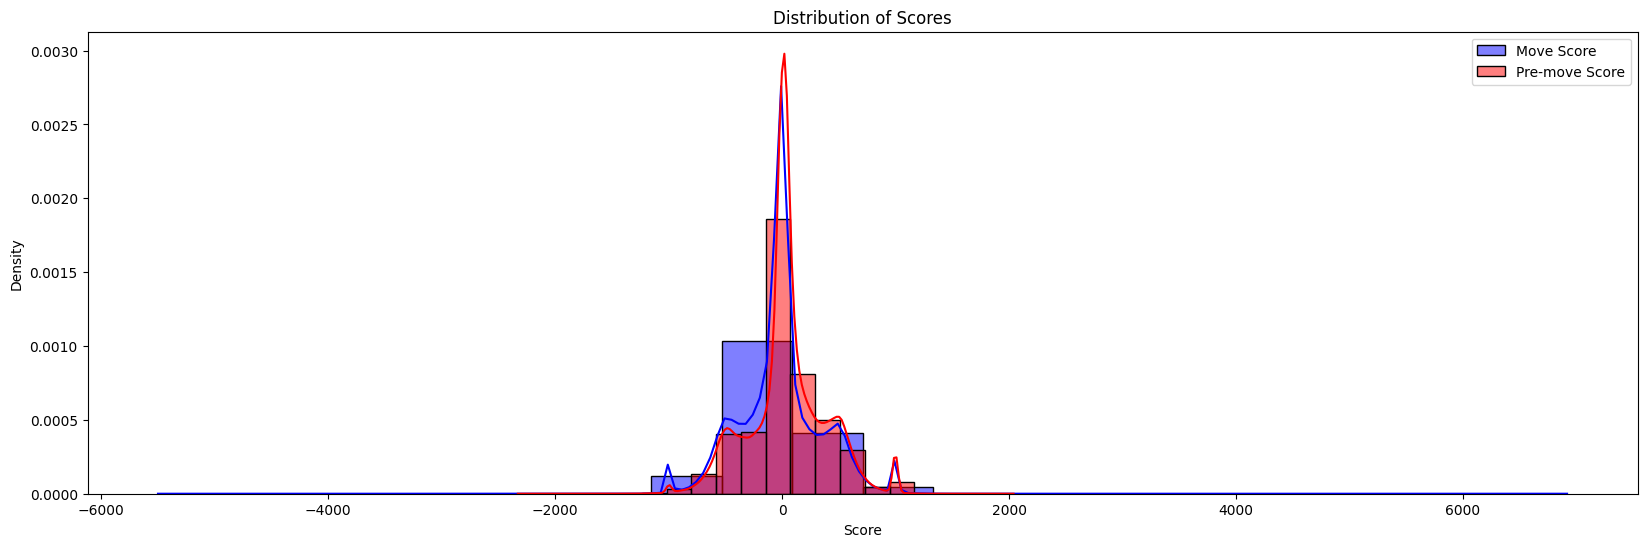

In [269]:
plt.figure(figsize=(20, 6))
sns.histplot(df['player_score'], kde=True, color='blue', label='Move Score', bins=20, stat="density")
sns.histplot(df['pre_move_score'], kde=True, color='red', label='Pre-move Score', bins=20, stat="density")

plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.show()

In the results we can see how the stockfish evaluation drops after a human move is played as usually they are suboptimal to the engine's recommendation

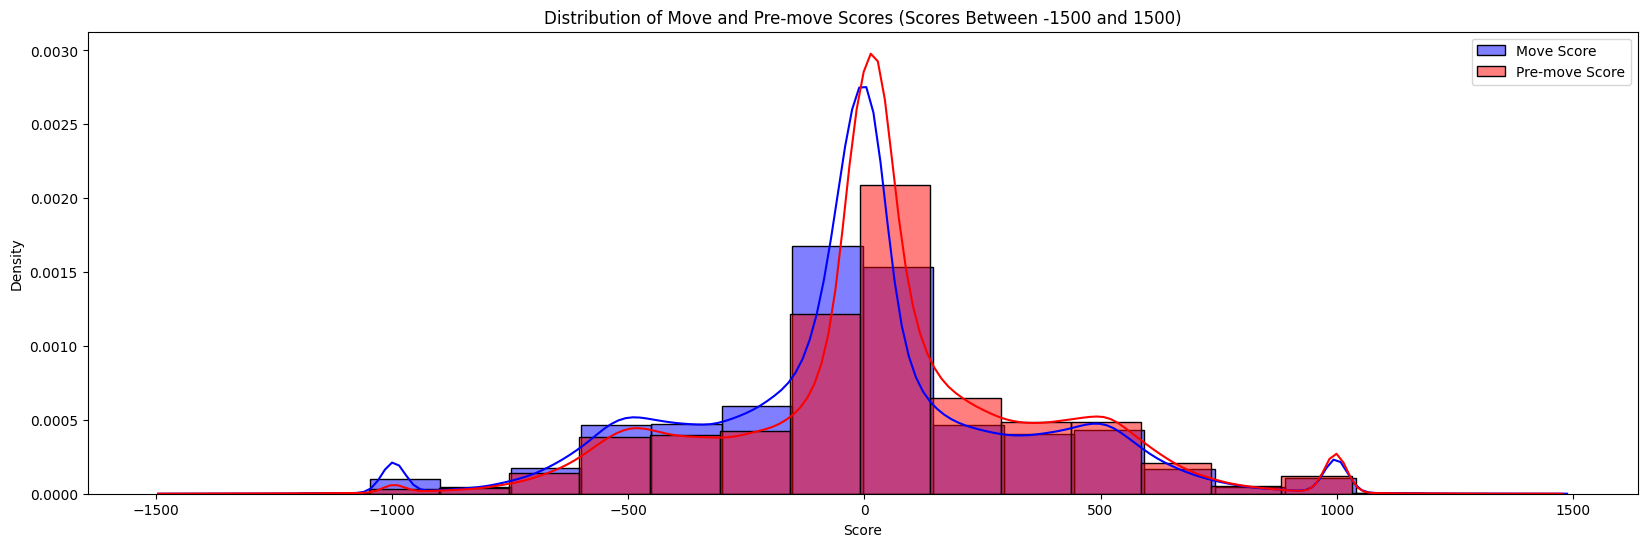

In [270]:
score_min = -1500
score_max = 1500

# Filter the DataFrame based on the score interval
filtered_df = df[(df['player_score'] >= score_min) & (df['player_score'] <= score_max) &
                 (df['pre_move_score'] >= score_min) & (df['pre_move_score'] <= score_max)]

plt.figure(figsize=(20, 6))
sns.histplot(filtered_df['player_score'], kde=True, color='blue', label='Move Score', bins=20, stat="density")
sns.histplot(filtered_df['pre_move_score'], kde=True, color='red', label='Pre-move Score', bins=20, stat="density")

plt.title(f'Distribution of Move and Pre-move Scores (Scores Between {score_min} and {score_max})')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.show()

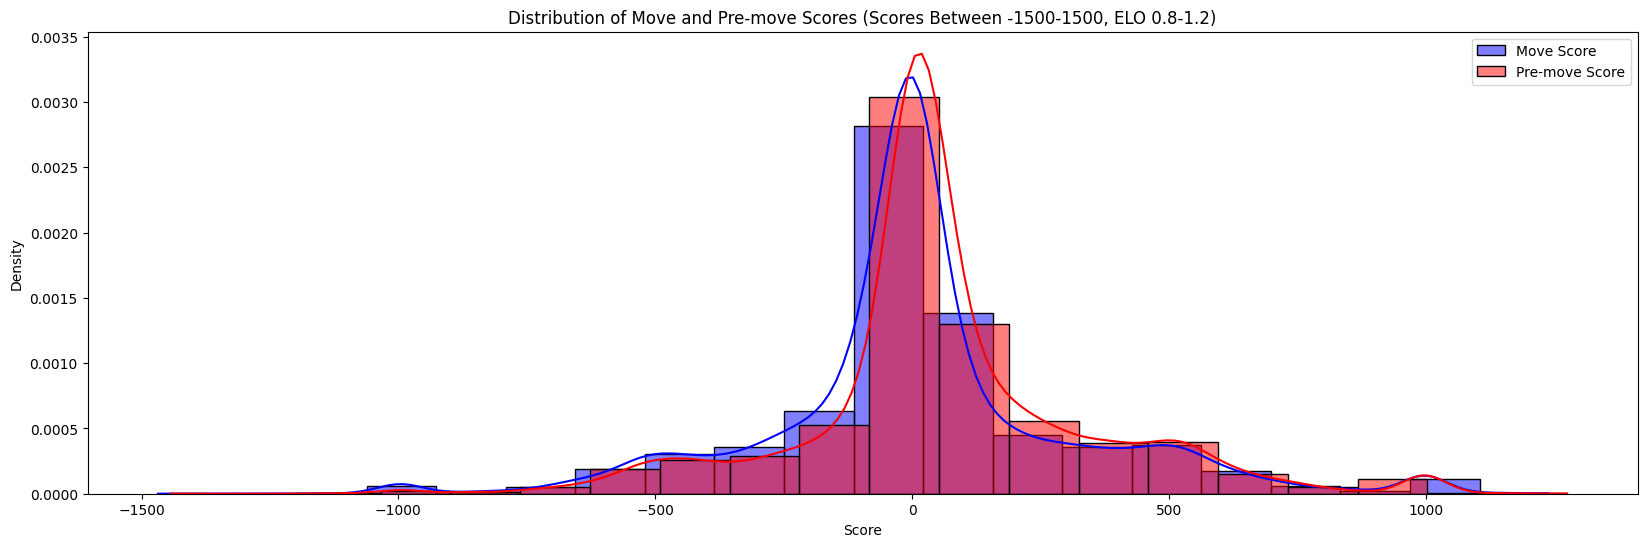

In [271]:
score_min, score_max = -1500, 1500
elo_min, elo_max = 0.8, 1.2

# Filter the DataFrame based on the score interval
filtered_df = df[(df['player_score'] >= score_min) & (df['player_score'] <= score_max) &
                 (df['pre_move_score'] >= score_min) & (df['pre_move_score'] <= score_max) &
                 (df['elo'] >= elo_min) & (df['elo'] <= elo_max)]


plt.figure(figsize=(20, 6))
sns.histplot(filtered_df['player_score'], kde=True, color='blue', label='Move Score', bins=20, stat="density")
sns.histplot(filtered_df['pre_move_score'], kde=True, color='red', label='Pre-move Score', bins=20, stat="density")

plt.title(f'Distribution of Move and Pre-move Scores (Scores Between {score_min}-{score_max}, ELO {elo_min}-{elo_max})')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.show()

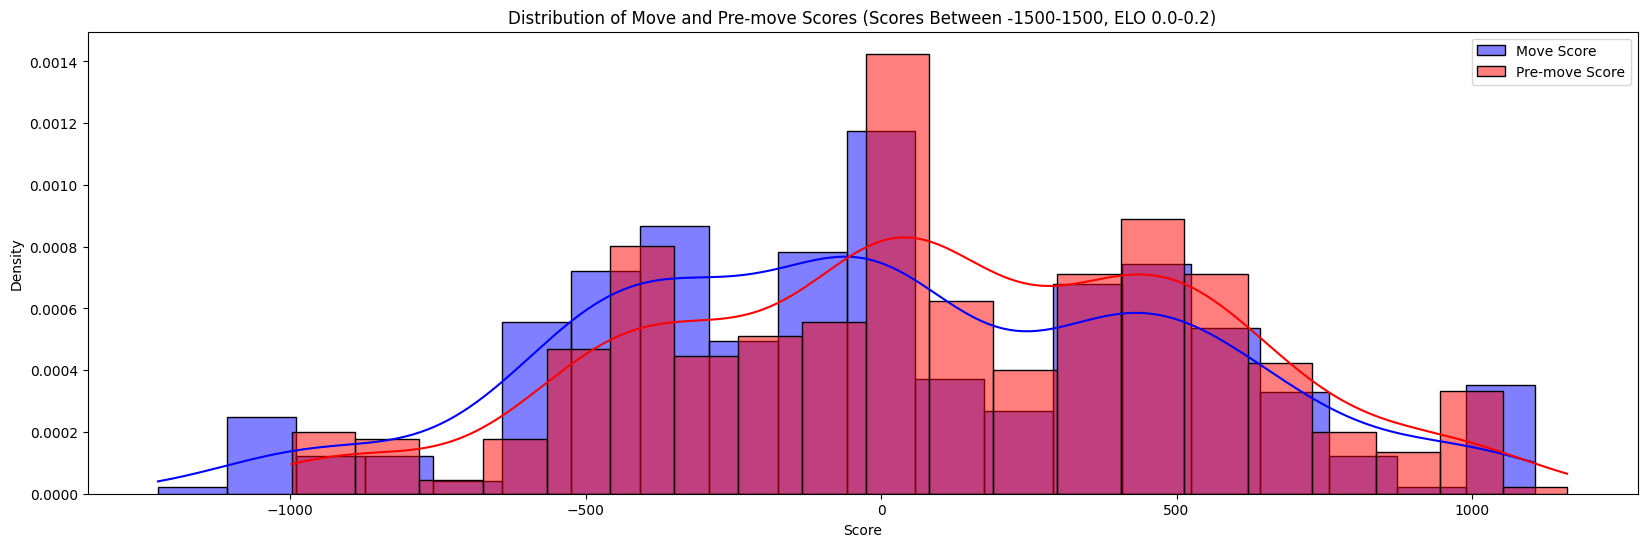

In [272]:
score_min, score_max = -1500, 1500
elo_min, elo_max = 0.0, 0.2

# Filter the DataFrame based on the score interval
filtered_df = df[(df['player_score'] >= score_min) & (df['player_score'] <= score_max) &
                 (df['pre_move_score'] >= score_min) & (df['pre_move_score'] <= score_max) &
                 (df['elo'] >= elo_min) & (df['elo'] <= elo_max)]


plt.figure(figsize=(20, 6))
sns.histplot(filtered_df['player_score'], kde=True, color='blue', label='Move Score', bins=20, stat="density")
sns.histplot(filtered_df['pre_move_score'], kde=True, color='red', label='Pre-move Score', bins=20, stat="density")

plt.title(f'Distribution of Move and Pre-move Scores (Scores Between {score_min}-{score_max}, ELO {elo_min}-{elo_max})')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.show()

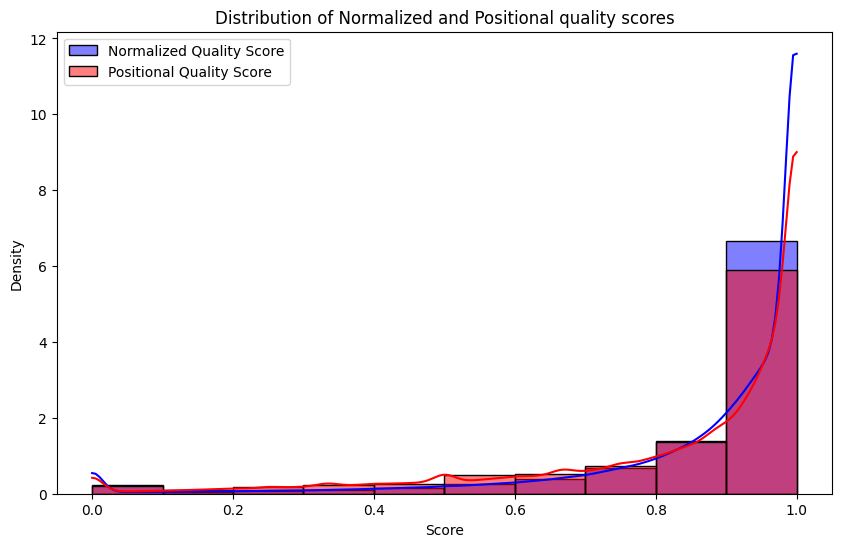

In [273]:
plt.figure(figsize=(10, 6))

sns.histplot(df['norm_score'], kde=True, color='blue', label='Normalized Quality Score', bins=10, stat="density")
sns.histplot(df['position_score'], kde=True, color='red', label='Positional Quality Score', bins=10, stat="density")

plt.title(f'Distribution of Normalized and Positional quality scores')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.show()

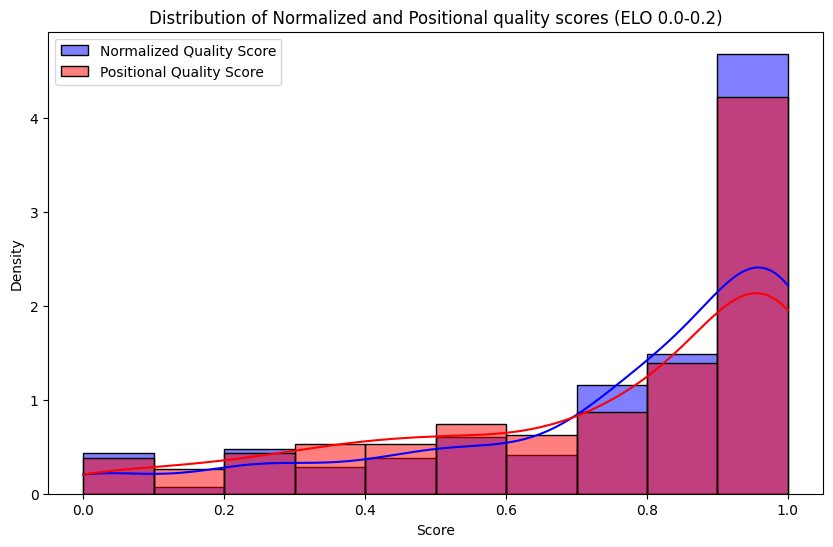

In [274]:
elo_min, elo_max = 0.0, 0.2

# Filter the DataFrame based on the score interval
filtered_df = df[(df['elo'] >= elo_min) & (df['elo'] <= elo_max)]

plt.figure(figsize=(10, 6))

sns.histplot(filtered_df['norm_score'], kde=True, color='blue', label='Normalized Quality Score', bins=10, stat="density")
sns.histplot(filtered_df['position_score'], kde=True, color='red', label='Positional Quality Score', bins=10, stat="density")

plt.title(f'Distribution of Normalized and Positional quality scores (ELO {elo_min}-{elo_max})')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.show()

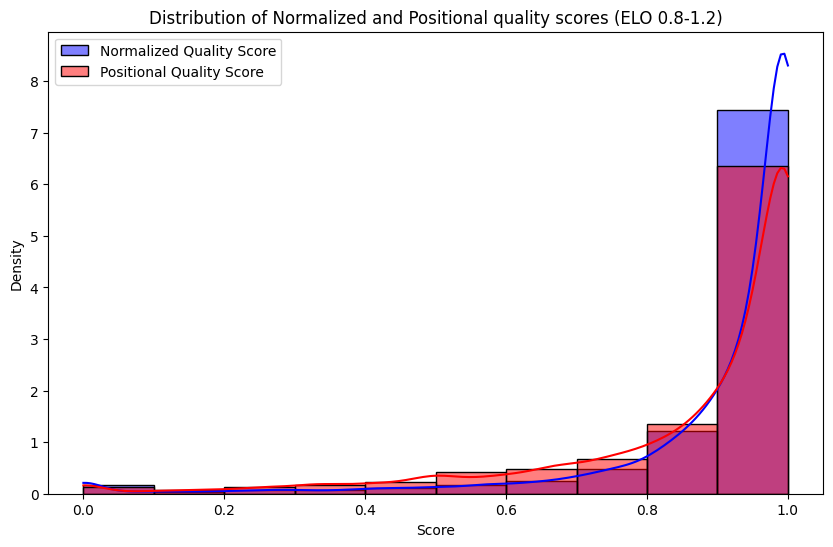

In [275]:
elo_min, elo_max = 0.8, 1.2

# Filter the DataFrame based on the score interval
filtered_df = df[(df['elo'] >= elo_min) & (df['elo'] <= elo_max)]

plt.figure(figsize=(10, 6))

sns.histplot(filtered_df['norm_score'], kde=True, color='blue', label='Normalized Quality Score', bins=10, stat="density")
sns.histplot(filtered_df['position_score'], kde=True, color='red', label='Positional Quality Score', bins=10, stat="density")

plt.title(f'Distribution of Normalized and Positional quality scores (ELO {elo_min}-{elo_max})')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.show()

#### Picking a score to be used in move picking

Pick move with score closest to:

In [308]:
def get_closest_move(moves, target_score):
    return min(moves, key=lambda move: abs(moves[move] - target_score))

In [304]:
target_score = np.random.choice(df.position_score)
target_score

1.0

In [ ]:
board = chess.Board()

engine = chess.engine.SimpleEngine.popen_uci(engine_path)
legal_moves = evaluate_all_moves_simple_engine(board, engine, time_limit=0.01)

engine.quit()

In [301]:
legal_moves

{Move.from_uci('g1h3'): 60,
 Move.from_uci('g1f3'): -29,
 Move.from_uci('b1c3'): 0,
 Move.from_uci('b1a3'): 60,
 Move.from_uci('h2h3'): 6,
 Move.from_uci('g2g3'): -11,
 Move.from_uci('f2f3'): 73,
 Move.from_uci('e2e3'): -16,
 Move.from_uci('d2d3'): 13,
 Move.from_uci('c2c3'): -2,
 Move.from_uci('b2b3'): 11,
 Move.from_uci('a2a3'): -3,
 Move.from_uci('h2h4'): 28,
 Move.from_uci('g2g4'): 127,
 Move.from_uci('f2f4'): 27,
 Move.from_uci('e2e4'): -30,
 Move.from_uci('d2d4'): -37,
 Move.from_uci('c2c4'): -19,
 Move.from_uci('b2b4'): 44,
 Move.from_uci('a2a4'): 16}

In [313]:
normalized_scores = get_normalized_scores(legal_moves)
print(get_closest_move(normalized_scores, target_score))
target_score, normalized_scores

g2g4


(1.0,
 {Move.from_uci('g1h3'): 0.5914634146341463,
  Move.from_uci('g1f3'): 0.04878048780487805,
  Move.from_uci('b1c3'): 0.22560975609756098,
  Move.from_uci('b1a3'): 0.5914634146341463,
  Move.from_uci('h2h3'): 0.2621951219512195,
  Move.from_uci('g2g3'): 0.15853658536585366,
  Move.from_uci('f2f3'): 0.6707317073170732,
  Move.from_uci('e2e3'): 0.12804878048780488,
  Move.from_uci('d2d3'): 0.3048780487804878,
  Move.from_uci('c2c3'): 0.21341463414634146,
  Move.from_uci('b2b3'): 0.2926829268292683,
  Move.from_uci('a2a3'): 0.2073170731707317,
  Move.from_uci('h2h4'): 0.39634146341463417,
  Move.from_uci('g2g4'): 1.0,
  Move.from_uci('f2f4'): 0.3902439024390244,
  Move.from_uci('e2e4'): 0.042682926829268296,
  Move.from_uci('d2d4'): 0.0,
  Move.from_uci('c2c4'): 0.10975609756097561,
  Move.from_uci('b2b4'): 0.49390243902439024,
  Move.from_uci('a2a4'): 0.3231707317073171})

In [312]:
positional_scores = get_positional_scores(legal_moves)
print(get_closest_move(positional_scores, target_score))
target_score, positional_scores

g2g4


(1.0,
 {Move.from_uci('d2d4'): 0.0,
  Move.from_uci('e2e4'): 0.05263157894736842,
  Move.from_uci('g1f3'): 0.10526315789473684,
  Move.from_uci('c2c4'): 0.15789473684210525,
  Move.from_uci('e2e3'): 0.21052631578947367,
  Move.from_uci('g2g3'): 0.2631578947368421,
  Move.from_uci('a2a3'): 0.3157894736842105,
  Move.from_uci('c2c3'): 0.3684210526315789,
  Move.from_uci('b1c3'): 0.42105263157894735,
  Move.from_uci('h2h3'): 0.47368421052631576,
  Move.from_uci('b2b3'): 0.5263157894736842,
  Move.from_uci('d2d3'): 0.5789473684210527,
  Move.from_uci('a2a4'): 0.631578947368421,
  Move.from_uci('f2f4'): 0.6842105263157894,
  Move.from_uci('h2h4'): 0.7368421052631579,
  Move.from_uci('b2b4'): 0.7894736842105263,
  Move.from_uci('g1h3'): 0.8421052631578947,
  Move.from_uci('b1a3'): 0.894736842105263,
  Move.from_uci('f2f3'): 0.9473684210526315,
  Move.from_uci('g2g4'): 1.0})